In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import os
import torch
import requests
import numpy as np
import torchvision.models as models
import matplotlib.pyplot as plt

from saliency.gradcam import GradCAM, GradCAMpp
from saliency.utils import visualize_cam
from visualization.visualization import visualize_mask
from PIL import Image

In [3]:
# Initialize a model, model_dict and GradCAM++
vgg = models.vgg16(pretrained=True)
vgg = torch.load('data/trained_model.pt', map_location=torch.device('cpu'))
vgg.eval()
vgg.double()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
model_dict = dict(
    activation_function='sigmoid',
    type='vgg',
    arch=vgg, 
    layer_name='layer1',
    input_size=(224, 224),
    verbose=True
)
Gcpp = GradCAMpp(model_dict)

In [5]:
# Random cat img taken from Google (10?)
#IMG_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg'
# Toilet paper (999)
IMG_URL = 'https://mcdonaldpaper.com/media/catalog/product/cache/3fba745dcec88e97bfe808bedc471260/b/w/bwk6145.jpg'

response = requests.get(IMG_URL)
# Read bytes and store as an img
img = Image.open(io.BytesIO(response.content))
#img = np.array(img)
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [6]:
import h5py
import joblib
import torchvision.transforms as transforms
import nibabel as nib
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from skimage import transform


class UnprocessedDataset(Dataset):
    def __init__(self, root_dir):
        self.files = os.listdir(root_dir)
        self.files = [file for file in self.files if file[-4:] != ".csv"]
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.files)
    
    def __get_file_path(self, idx, postfix):
        return self.root_dir + "/" + self.files[idx] + "/" + self.files[idx] + "_" + postfix + ".nii"
    
    def __getitem__(self, index):
        if type(index) == tuple:
            idx, s = index
        else:
            idx, s = index, slice(None, None)
        images = [
            nib.load(self.__get_file_path(idx, postfix)) 
            for postfix in ["flair", "t1", "t2", "t1ce"]
        ]
        images = np.array([np.asanyarray(image.dataobj) for image in images])
        images = np.swapaxes(images, 0, 3)
        images = images[s]
        """y = np.array(nib.load(self.__get_file_path(idx, "")).dataobj)
        y = np.moveaxis(y, 2, 0)
        y = y[s]
        y = np.any(y, (0,1))"""
        return images #, y


def load_HDF5_img(path: str):
    """Load .hdf5 image as PIL Image"""
    assert path.endswith('.h5'), 'file must have hdf5-format'
    with h5py.File(path, 'r') as h5_img:
        assert 'image' in h5_img.keys()
        return Image.fromarray(h5_img['image'][:, :, :3], 'RGB')
    
    
def transform_img_old(img, min_img_size=224) -> torch.Tensor:
    """Preprocess using a transform pipeline"""
    img_reduced = img # remove
    to_pipeline = [
        # PCA()
        transforms.Resize(min_img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[1/2]*3, std=[1/5]*3),
    ]
    transform_pipeline = transforms.Compose(to_pipeline)
    img_transformed = transform_pipeline(img_reduced).unsqueeze(0)
    return Variable(img_transformed)


pipeline = joblib.load("data/pipeline.pkl")
transformation = lambda x: np.resize(
    transform.resize(
        np.resize(
            pipeline.transform(
                np.resize(x, (240*240, 4))
            ), (240, 240, 4)
        ), (224, 224)
    ), (3, 224, 224)
)

def transform_img(img, transform_lambda):
    t_tensor = torch.tensor(transform_lambda(img))[None, :, :, :]
    return Variable(t_tensor).double()

In [7]:

img_transformed = transform_img(img, transformation)
#img_transformed = transform_img_old(img)
type(img_transformed[0, 0, 0, 0]), img_transformed.shape
#plt.imshow(img_transformed.permute(1, 2, 0))

(torch.Tensor, torch.Size([1, 3, 224, 224]))

In [8]:
# Get a GradCAM saliency map on the class index.
mask, logit = Gcpp(img_transformed, class_idx=0)
heatmap, cam_result = visualize_cam(mask, img_transformed)

/home/markus/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
/home/markus/.local/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


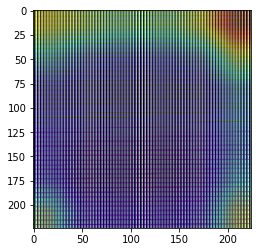

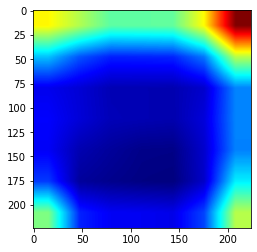

In [9]:
plt.imshow(cam_result.permute(1, 2, 0))
plt.show()

plt.figure()
plt.imshow(heatmap.permute(1, 2, 0))
plt.show()

In [10]:
import os
from scipy.signal import resample_poly
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore") 

def mock_transform(img):
    ttensor = torch.tensor(img[:, :, 1:]).permute(2, 0, 1)
    return Variable(ttensor[None, :, :, :]).double()

# Transform and GradCAM++ images
training_data = UnprocessedDataset("data/sample_volume")
class_index = 0 # tumor?
slice_masks = []
sample_volume = training_data[0]
for brain_slice in tqdm(sample_volume): # Sample volume
    #img_transformed = transform_img(brain_slice, transformation)
    img_transformed = mock_transform(brain_slice)
    mask, _ = Gcpp(img_transformed, class_idx=class_index)
    np_mask = mask[0, 0, :].numpy()
    slice_masks.append(np_mask)
mask_3d = np.stack(slice_masks)

100%|██████████| 155/155 [10:37<00:00,  4.11s/it]


### Computing 3D brain contour  
Might be helpful for visualizing where in the particular brain the network sees areas of interest.

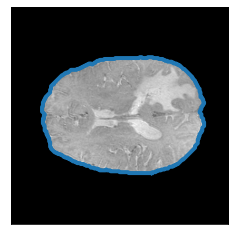

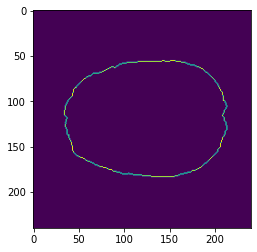

In [60]:
from skimage import measure
from matplotlib import image


def rgb_to_grayscale(rgb: np.ndarray) -> np.ndarray:
    """RGB to graysc of ndarray using PIL."""
    vol_max = rgb.max()
    np_normalized = (rgb / vol_max * 255).astype(np.uint8)
    r = Image.fromarray(np_normalized).convert('L')
    return np.array(r)


def contour_matrix(r: np.ndarray) -> np.ndarray:
    """2D contours of grayscale image r."""
    contours = measure.find_contours(r, 1)
    contour_matrix = np.zeros(r.shape)
    if not len(contours):
        return contour_matrix
    for x, y in contours[0]:
        contour_matrix[round(x), round(y)] = 1
    return contour_matrix
    

def compute_brain_hull(volume: np.ndarray) -> np.ndarray:
    """3D contours of volume represented as a sparse matrix of volume shape."""
    contour_tensor = []
    for idx in range(volume.shape[0]): # idx x 240 x 240 x 4
        img = volume[idx, :, :, 1:]
        r = rgb_to_grayscale(img)
        contour_tensor.append(contour_matrix(r))
    return np.array(contour_tensor)


def compute_brain_hull_idxs(volume: np.ndarray) -> np.ndarray:
    """x, y, z of 3D contours of volume for 3d mesh gen."""
    contour_tensor = []
    for idx in range(volume.shape[0]): # idx x 240 x 240 x 4
        img = volume[idx, :, :, 1:]
        r = rgb_to_grayscale(img)
        conts = np.array(measure.find_contours(r, 1))
        z = idx * np.ones(len(conts))
        xyz = np.block([conts, z])
        print(conts) # fix
        contour_tensor.append(xyz) 
    return np.array(contour_tensor)


# Preprocess sample
idx = 80
img = sample_volume[idx, :, :, 1:]
r = rgb_to_grayscale(img)

contours = measure.find_contours(r, 1)
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=4)
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
    
contour_m = contour_matrix(r)
plt.imshow(contour_m)
plt.show()

In [62]:
brain_hull = compute_brain_hull(sample_volume)
#brain_hull_idxs = compute_brain_hull_idxs(sample_volume)
#brain_hull_idxs

In [13]:
# Downsample volume hull
hull_downsampled = np.nan_to_num(brain_hull.copy())
for k in range(3):
    hull_downsampled = resample_poly(
        hull_downsampled, 1, 8, axis=k
    )
    
# Downsample brain volume mask
mask_downsampled = np.nan_to_num(mask_3d.copy())
for k in range(3):
    mask_downsampled = resample_poly(
        mask_downsampled, 1, 8, axis=k
    )

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
from dash.dependencies import Input, Output, State


# Prep fig
nd_slice = slice(0, mask_downsampled.shape[1], 1)
filled = np.add(mask_downsampled, hull_downsampled)
fig = visualize_mask(filled, ndgrid_idxs=nd_slice)

# Init dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id="graph", 
        figure=fig, 
        style={'height': '800px'}
    ),
    daq.ToggleSwitch(
        label='Brain contours',
        labelPosition='bottom',
        value=False,
        size=80,
        id='contour-toggle',
    )
])

@app.callback(
    Output("graph", "figure"), [Input("contour-toggle", "value")]
)
def toggle_contours(toggle_val):
    global filled, hull_downsampled
    if not toggle_val:
        filled = np.add(filled, -hull_downsampled)
    else:
        filled = np.add(filled, hull_downsampled)
    return visualize_mask(filled, ndgrid_idxs=nd_slice)


"""@app.callback(
    Output("graph", "figure"), 
    [Input("contour-toggle", "value"), Input('graph', 'figure')]
)
def toggle_contours(toggle_val, fig):
    global filled, hull_downsampled
    if toggle_val:
        filled = np.add(filled, -hull_downsampled)
    else:
        filled = np.add(filled, hull_downsampled)
    return visualize_mask(filled, ndgrid_idxs=nd_slice)"""


#fig1.add_trace(go.Mesh3d(x=x, y=y, z=z-2, color='cyan', opacity=0.50))
    
"""
@app.callback(
    Output("graph", "figure"), Input("outside-toggle", "value")
)
def toggle_outside(toggle_val):
    global filled, hull_downsampled
    print('asasd')
"""
app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Mar/2021 14:50:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 14:50:29] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 14:50:29] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 14:50:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 14:51:19] "POST /_dash-update-component HTTP/1.1" 200 -


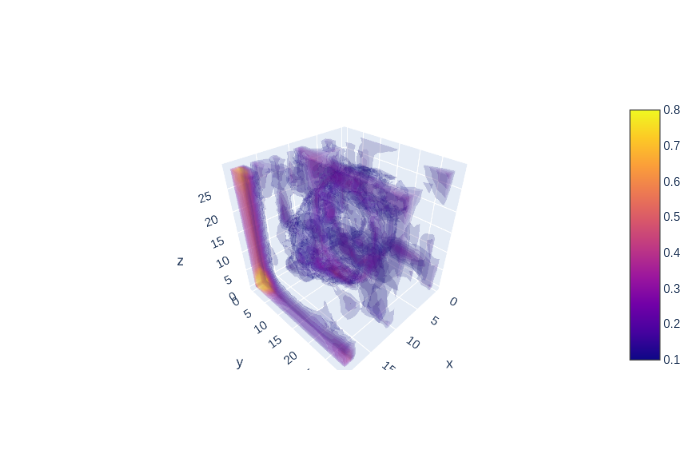

In [33]:
fig.show(renderer='png')

In [55]:
 """daq.ToggleSwitch(
        label='Disable outside brain activation',
        labelPosition='bottom',
        value=False,
        size=80,
        id='outside-toggle',
        style={'display': 'inline-block'}
    )"""

"daq.ToggleSwitch(\n       label='Disable outside brain activation',\n       labelPosition='bottom',\n       value=False,\n       size=80,\n       id='outside-toggle',\n       style={'display': 'inline-block'}\n   )"